In [1]:
!pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv -y
!pip uninstall torch_geometric -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html
!pip install torch_geometric

# Install remaining packages
!pip install --upgrade pandas
!pip install --upgrade matplotlib
!pip install --upgrade node2vec
!pip install --upgrade scikit-learn
!pip install pyvis

# Install from git repo
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch_sparse
# import pyg_lib
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import Node2Vec, FastRGCNConv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, average_precision_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.loader import GraphSAINTRandomWalkSampler
from torch_geometric.data import Data, NeighborSampler, GraphSAINTEdgeSampler
import networkx as nx
from gensim.models import Word2Vec
from torch_geometric.utils import negative_sampling
# from torch_geometric.utils import contains_isolated_nodes
from torch_sparse import SparseTensor
from tqdm import tqdm

Found existing installation: torch_scatter 2.1.2+pt23cpu
Uninstalling torch_scatter-2.1.2+pt23cpu:
  Successfully uninstalled torch_scatter-2.1.2+pt23cpu
Found existing installation: torch_sparse 0.6.18+pt23cpu
Uninstalling torch_sparse-0.6.18+pt23cpu:
  Successfully uninstalled torch_sparse-0.6.18+pt23cpu
Found existing installation: torch_cluster 1.6.3+pt23cpu
Uninstalling torch_cluster-1.6.3+pt23cpu:
  Successfully uninstalled torch_cluster-1.6.3+pt23cpu
Found existing installation: torch_spline_conv 1.2.2+pt23cpu
Uninstalling torch_spline_conv-1.2.2+pt23cpu:
  Successfully uninstalled torch_spline_conv-1.2.2+pt23cpu
Found existing installation: torch_geometric 2.5.3
Uninstalling torch_geometric-2.5.3:
  Successfully uninstalled torch_geometric-2.5.3
Looking in indexes: https://download.pytorch.org/whl/cpu
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.3.0%2Bcpu/torch_scatter-2.1.2%2Bpt23cpu-cp310-cp310-linux_x86_64.wh

In [ ]:
# !python --version

In [2]:
from google.colab import drive
# importing the dataset from google drive
drive.mount('/content/drive')


!ls '/content/drive/My Drive/ML'
data = pd.read_csv('/content/drive/My Drive/ML/kg.csv', low_memory=False)

# data.head()

Mounted at /content/drive
evaluations.csv  kg.csv  results-bert.csv  submissions-bert.csv  train.json


In [3]:
data.query('y_type=="disease"|x_type=="disease"')

relation  display_relation  x_index                 x_id  \
346728   contraindication  contraindication    15193              DB05271   
346729   contraindication  contraindication    15193              DB05271   
346730         indication        indication    16687              DB00492   
346731         indication        indication    16687              DB00492   
346732   contraindication  contraindication    14483              DB13956   
...                   ...               ...      ...                  ...   
6499510  exposure_disease         linked to    31393                11565   
6499511  exposure_disease         linked to    28208                 5148   
6499512  exposure_disease         linked to    84172                 1076   
6499513  exposure_disease         linked to    33063               100130   
6499514  exposure_disease         linked to    28668  9976_4580_1451_1455   

          x_type                                     x_name       x_source  \
346728      drug                                 Rotigotine       DrugBank   
346729      drug                                 Rotigotine       DrugBank   
346730      drug                                 Fosinopril       DrugBank   
346731      drug                                 Fosinopril       DrugBank   
346732      drug                         Estradiol valerate       DrugBank   
...          ...                                        ...            ...   
6499510  disease                       metabolic syndrome X          MONDO   
6499511  disease                   type 2 diabetes mellitus          MONDO   
6499512  disease                        glucose intolerance          MONDO   
6499513  disease  adult acute respiratory distress syndrome          MONDO   
6499514  disease                       retinal degeneration  MONDO_grouped   

         y_index                         y_id    y_type  \
346728     33577                         5044   disease   
346729     36035  1200_1134_15512_5080_100078   disease   
346730     33577                         5044   disease   
346731     36035  1200_1134_15512_5080_100078   disease   
346732     33577                         5044   disease   
...          ...                          ...       ...   
6499510    61825                      D015032  exposure   
6499511    61825                      D015032  exposure   
6499512    61825                      D015032  exposure   
6499513    61825                      D015032  exposure   
6499514    62183                      D015039  exposure   

                        y_name       y_source  
346728   hypertensive disorder          MONDO  
346729            hypertension  MONDO_grouped  
346730   hypertensive disorder          MONDO  
346731            hypertension  MONDO_grouped  
346732   hypertensive disorder          MONDO  
...                        ...            ...  
6499510                   Zinc            CTD  
6499511                   Zinc            CTD  
6499512                   Zinc            CTD  
6499513                   Zinc            CTD  
6499514                  Ziram            CTD  

[618100 rows x 12 columns]

### Data Preparation

In [4]:
# Filter rows where x_type is 'drug' and y_type is 'disease'
drug_disease_df = data[(data['x_type'] == 'drug') & (data['y_type'] == 'disease')]
drug_disease_df

relation  display_relation  x_index     x_id x_type  \
346728  contraindication  contraindication    15193  DB05271   drug   
346729  contraindication  contraindication    15193  DB05271   drug   
346730        indication        indication    16687  DB00492   drug   
346731        indication        indication    16687  DB00492   drug   
346732  contraindication  contraindication    14483  DB13956   drug   
...                  ...               ...      ...      ...    ...   
389354        indication        indication    16634  DB00036   drug   
389355        indication        indication    16634  DB00036   drug   
389356        indication        indication    16634  DB00036   drug   
389357  contraindication  contraindication    18277  DB01202   drug   
389358        indication        indication    17237  DB00967   drug   

                                           x_name  x_source  y_index  \
346728                                 Rotigotine  DrugBank    33577   
346729                                 Rotigotine  DrugBank    36035   
346730                                 Fosinopril  DrugBank    33577   
346731                                 Fosinopril  DrugBank    36035   
346732                         Estradiol valerate  DrugBank    33577   
...                                           ...       ...      ...   
389354  Coagulation factor VIIa Recombinant Human  DrugBank    27527   
389355  Coagulation factor VIIa Recombinant Human  DrugBank    38622   
389356  Coagulation factor VIIa Recombinant Human  DrugBank    28673   
389357                              Levetiracetam  DrugBank    84334   
389358                              Desloratadine  DrugBank    39497   

                               y_id   y_type  \
346728                         5044  disease   
346729  1200_1134_15512_5080_100078  disease   
346730                         5044  disease   
346731  1200_1134_15512_5080_100078  disease   
346732                         5044  disease   
...                             ...      ...   
389354           31332_100326_31009  disease   
389355                         2244  disease   
389356                         9211  disease   
389357                         1186  disease   
389358                         6526  disease   

                                  y_name       y_source  
346728             hypertensive disorder          MONDO  
346729                      hypertension  MONDO_grouped  
346730             hypertensive disorder          MONDO  
346731                      hypertension  MONDO_grouped  
346732             hypertensive disorder          MONDO  
...                                  ...            ...  
389354          Glanzmann thrombasthenia  MONDO_grouped  
389355             factor VII deficiency          MONDO  
389356  congenital factor VII deficiency          MONDO  
389357        depersonalization disorder          MONDO  
389358                allergic urticaria          MONDO  

[42631 rows x 12 columns]

In [6]:
# Extract triples (relationship in the form: subject, relation, object)
triples = drug_disease_df[['x_name','y_name','relation']]

# creating a dataframe of triples
triples_df = pd.DataFrame({'drug': triples['x_name'],
                           'disease': triples['y_name'],
                           'relation_type': triples['relation']
                          })
triples_df

drug  \
346728                                 Rotigotine   
346729                                 Rotigotine   
346730                                 Fosinopril   
346731                                 Fosinopril   
346732                         Estradiol valerate   
...                                           ...   
389354  Coagulation factor VIIa Recombinant Human   
389355  Coagulation factor VIIa Recombinant Human   
389356  Coagulation factor VIIa Recombinant Human   
389357                              Levetiracetam   
389358                              Desloratadine   

                                 disease     relation_type  
346728             hypertensive disorder  contraindication  
346729                      hypertension  contraindication  
346730             hypertensive disorder        indication  
346731                      hypertension        indication  
346732             hypertensive disorder  contraindication  
...                                  ...               ...  
389354          Glanzmann thrombasthenia        indication  
389355             factor VII deficiency        indication  
389356  congenital factor VII deficiency        indication  
389357        depersonalization disorder  contraindication  
389358                allergic urticaria        indication  

[42631 rows x 3 columns]

In [7]:
# Number of unique drugs
unique_drugs = triples_df['drug'].nunique()

# Number of unique diseases
unique_diseases = triples_df['disease'].nunique()

print(f"Number of unique drugs: {unique_drugs}")
print(f"Number of unique diseases: {unique_diseases}")

Number of unique drugs: 2074
Number of unique diseases: 2054


### Known disease associations for a given drug (will be used later for predictions)


In [8]:
drug_name = "Levetiracetam"
drug_triples = drug_disease_df[drug_disease_df['x_name'] == drug_name]

# get the indications and contraindications
indications = drug_triples[drug_triples['relation'] == 'indication']['y_name'].tolist()
contraindications = drug_triples[drug_triples['relation'] == 'contraindication']['y_name'].tolist()
off_label_use = drug_triples[drug_triples['relation'] == 'off-label use']['y_name'].tolist()

print(f"Drug: {drug_name}\n")
print(f"Indications: {indications}\n")
print(f"Contraindications: {contraindications}\n")
print(f"Off-label_use: {off_label_use}\n")

Drug: Levetiracetam

Indications: ['partial epilepsy']

Contraindications: ['anxiety disorder', 'neurotic disorder', 'dysthymic disorder', 'kidney disease', 'pyoureter', 'liver disease', 'gallbladder disease', 'psychotic disorder', 'schizophreniform disorder', 'mental disorder', 'schizoaffective disorder', 'neutropenia', 'agranulocytosis', 'leukopenia', 'pancytopenia', 'anxiety', 'depersonalization disorder']

Off-label_use: []



### Creating the graph using networkx


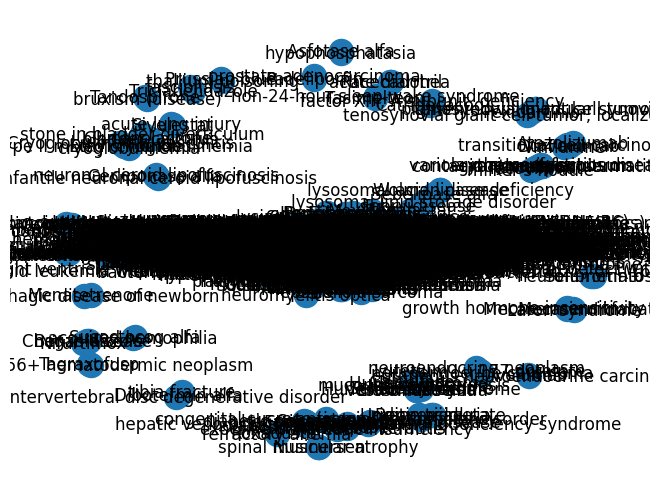

In [9]:
# Create a graph from the dataframe using networkx
G = nx.from_pandas_edgelist(triples_df, source='drug', target= 'disease', edge_attr= 'relation_type')

nx.draw(G, with_labels=True)

In [10]:
import json
from pyvis.network import Network
from IPython.display import IFrame, display, HTML

# Creating the Pyvis network
net = Network(notebook=True, cdn_resources='in_line')

# Adding nodes and edges from NetworkX graph to Pyvis network
for node in G.nodes():
    # Check if the node is a drug or disease
    if node in triples_df['drug'].values:
        color = '#6495ED'  # Blue for drugs
    else:
        color = '#FF6347'  # Red for diseases
    net.add_node(node, color=color)

for edge in G.edges(data=True):
    # Check if there's any data for this edge
    if edge[2]:
        # Use the first key-value pair in the edge data as the title
        title = f"{list(edge[2].keys())[0]}: {list(edge[2].values())[0]}"
    else:
        title = ""
    net.add_edge(edge[0], edge[1], title=title)

# Set options for the network visualization
options = {
    "nodes": {
        "shape": "dot",
        "size": 20
    },
    "edges": {
        "color": {
            "inherit": True
        },
        "smooth": False
    },
    "physics": {
        "forceAtlas2Based": {
            "gravitationalConstant": -25,
            "centralGravity": 0.005,
            "springLength": 200,
            "springConstant": 0.04,
            "damping": 0.9
        },
        "minVelocity": 0.1,
        "maxVelocity": 10,
        "solver": "forceAtlas2Based",
        "stabilization": {
            "enabled": True,
            "iterations": 1000,
            "updateInterval": 50
        },
        "timestep": 0.3
    }
}

# Convert the Python dictionary to a JSON string
options_json = json.dumps(options)

# Set the options
net.set_options(options_json)

# Save and read the HTML file
net.save_graph("network.html")
with open("network.html", "r", encoding="utf-8") as f:
    html = f.read()

# Display the network
display(HTML(html))

### Encoding the drugs and disease nodes using Node2vec algorithm


In [ ]:
from scipy.linalg import triu
from node2vec import Node2Vec

# Training the model on the graph
node2vec = Node2Vec(G, dimensions=64, walk_length=10, num_walks=100, workers=3)
my_model = node2vec.fit(window=10,min_count=1)

# Obtaining drug and disease names
drugs = list(triples_df['drug'])
diseases = list(triples_df['disease'])

Computing transition probabilities:   0%|          | 0/4128 [00:00<?, ?it/s]

In [ ]:
# create a mapping for drugs and diseases - basically giving each unique drug and disease a unique index
# we will use it for the edge_index

drug_mapping = {drug:idx for idx,drug in enumerate(set(drugs))}
disease_mapping = {disease:idx + len(drug_mapping) for idx, disease in enumerate(set(diseases))}
# disease_mapping

In [ ]:
# create a mapping for drugs and diseases - basically giving each unique drug and disease a unique index
# we will use it for the edge_index

drug_mapping = {drug:idx for idx,drug in enumerate(set(drugs))}
disease_mapping = {disease:idx + len(drug_mapping) for idx, disease in enumerate(set(diseases))}
# disease_mapping

In [ ]:
# Embeddings - learning low dimensional representations of nodes and converting to a tensor
all_nodes = list(set(drugs+diseases))
node_embeddings = [torch.tensor(my_model.wv[node], dtype=torch.float) for node in all_nodes]

In [ ]:
# Combining the embeddings into a single tensor (our node feature tensor for pytorch geometric)
x = torch.stack(node_embeddings,dim=0)
x

tensor([[ 3.9864e-01,  6.5900e-03, -2.0427e-01,  ..., -2.6305e-01,
         -1.8364e-01, -3.5496e-01],
        [ 3.0510e-01,  2.6594e-02, -8.0410e-02,  ..., -1.2834e-01,
          8.5178e-02, -3.8497e-01],
        [ 3.6591e-01, -1.9146e-01, -1.0125e-02,  ..., -4.7601e-01,
         -1.4253e-01, -5.1603e-01],
        ...,
        [-2.0139e-01,  5.9138e-02,  3.4955e-01,  ..., -1.1981e-01,
          2.4684e-01,  4.2446e-01],
        [ 2.1800e-02,  8.7371e-03,  2.9848e-01,  ..., -2.3707e-04,
         -1.5733e-02,  2.6279e-01],
        [ 1.1742e-01,  2.8505e-01,  5.4553e-01,  ..., -3.0950e-01,
          1.5244e-01,  6.3384e-02]])

In [ ]:
# Creating the edge_index tensor
source = [drug_mapping[row['drug']]for _, row in triples_df.iterrows()]
destination = [disease_mapping[row['disease']]for _, row in triples_df.iterrows()]

edge_index = torch.tensor([source,destination],dtype=torch.long)
edge_index

tensor([[1824, 1824, 1663,  ...,  787,  636,  631],
        [3742, 2687, 3742,  ..., 4075, 3913, 3137]])

In [ ]:
# Creating the edge_attr tensor -  since there are only two relation types, indication and contraindication:
# we have 0 and 1 respectively

relation_map = {'indication':0, 'contraindication':1, 'off-label use': 2}
edge_attr = torch.tensor([relation_map[row['relation_type']]for _,row in triples_df.iterrows()])
edge_attr

tensor([1, 1, 0,  ..., 0, 1, 0])

In [ ]:
# Obtain the unique relation types from the dataframe
unique_relations = triples_df['relation_type'].unique()

# Map relation types to indices
relation_type_mapping = {relation_type: idx for idx, relation_type in enumerate(unique_relations)}

# Map relation types to indices for each edge in edge_index
edge_type = torch.tensor([relation_type_mapping[relation_type] for relation_type in unique_relations], dtype=torch.long)


# Repeat the edge_type tensor to match the number of edges
edge_type = edge_type.repeat(42631 // len(unique_relations) + 1)[:42631]
edge_type.shape

torch.Size([42631])

In [ ]:
edge_index_arr = torch.arange(edge_index.shape[1])

# Training and testing sets
train_edge_index, val_edge_index = train_test_split(edge_index_arr, test_size=0.2, random_state=42)

# creating boolean masks based on the indicies from train_test_split
train_mask, val_mask = torch.zeros_like(edge_index_arr).bool(),torch.zeros_like(edge_index_arr).bool()
train_mask[train_edge_index] = 1
val_mask[val_edge_index] = 1

train_mask,val_mask


(tensor([False, False,  True,  ...,  True,  True,  True]),
 tensor([ True,  True, False,  ..., False, False, False]))

In [ ]:
# Creating pytorch geometric data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, edge_type=edge_type, train_mask=train_mask,val_mask=val_mask)
data

Data(x=[4128, 64], edge_index=[2, 42631], edge_attr=[42631], edge_type=[42631], train_mask=[42631], val_mask=[42631])

In [ ]:
data.test_neg_mask = negative_sampling(data.edge_index, num_neg_samples=data.val_mask.sum())


## Preparing the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Building the Graph neural network model

In [ ]:
# Relational Graph Convolutional Network Model
class RGCN(torch.nn.Module):
    def __init__(self, in_dim, h_dim, out_dim, num_relations):
        super(RGCN, self).__init__()
        self.num_relations = num_relations
        self.conv1 = FastRGCNConv(in_dim, h_dim, num_relations, aggr='mean')
        self.conv2 = FastRGCNConv(h_dim, out_dim, num_relations, aggr='mean')
        self.relu = nn.ReLU()
        self.w_rels = nn.Parameter(torch.Tensor(num_relations, out_dim))
        nn.init.xavier_uniform_(self.w_rels, gain=nn.init.calculate_gain('relu'))

    def forward(self, x, edge_index, edge_type):
        x1 = self.conv1(x, edge_index, edge_type)
        x1 = self.relu(x1)
        x2 = self.conv2(x1, edge_index, edge_type)
        out = F.log_softmax(x2, dim=1)

        return out

def get_metrics(model, embed, edge_index, edge_type, labels):
    probs = DistMult(embed, edge_index, edge_type, model)
    loss = F.binary_cross_entropy(probs, labels)
    probs = probs.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    return loss, probs, labels

def DistMult(embed, edge_index, edge_type, model):
    s = embed[edge_index[0, :]]
    o = embed[edge_index[1, :]]
    r = model.w_rels[edge_type]
    scores = torch.sum(s * r * o, dim=1)
    return torch.sigmoid(scores)

def get_link_labels(edge_index_pos_len, edge_index_neg_len):
    link_labels = torch.zeros(edge_index_pos_len + edge_index_neg_len).float().to(device)
    link_labels[:int(edge_index_pos_len)] = 1.
    return link_labels

def get_embeddings(data):
    data = data.to(device)
    x = data.x
    edge_index_pos = data.edge_index
    edge_type = torch.squeeze(data.edge_type)
    embed = model(x, edge_index_pos, edge_type)

    return embed

In [ ]:
# Initializing the model
# data.x.size(1)
model = RGCN(in_dim=data.x.size(1), h_dim=64, out_dim=64, num_relations=len(unique_relations)).to(device)
model

RGCN(
  (conv1): FastRGCNConv(64, 64, num_relations=3)
  (conv2): FastRGCNConv(64, 64, num_relations=3)
  (relu): ReLU()
)

In [ ]:
# define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-5)

In [ ]:
data.x = data.x.to(torch.float)
data.edge_index = data.edge_index.to(torch.long)
data.edge_attr = data.edge_attr.to(torch.long)
data.edge_type = data.edge_type.to(torch.long)

In [ ]:
# Sampling fully connected subgraphs for training
# import torch_geometric.utils as tg_utils

# data.edge_index = data.edge_index.to(torch.long)

# data.adj = tg_utils.to_dense_adj(data)


# data_loader = NeighborLoader(
#     data,
#     num_neighbors=[15, 10],  # One entry per layer
#     batch_size=50,
#     input_nodes=None,  # To be set dynamically for train, val, test
# )
data_loader = GraphSAINTRandomWalkSampler(data, batch_size=50, walk_length=3, num_steps=12)
data_loader

In [ ]:
num_relations=len(unique_relations)
num_relations

3

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def train(data, embed):
    data = data.to(device)
    x = data.x
    edge_index_train_pos = data.edge_index[:, data.train_mask]
    edge_type_train = torch.squeeze(data.edge_type[data.train_mask])
    edge_index_train_neg = negative_sampling(edge_index_train_pos, num_neg_samples=data.train_mask.sum())
    edge_index_train_total = torch.cat([edge_index_train_pos, edge_index_train_neg], dim=-1)
    edge_type_train_total = torch.cat([edge_type_train, edge_type_train[:edge_index_train_neg.size(1)]], dim=-1)
    link_labels = get_link_labels(edge_index_train_pos.size(1), edge_index_train_neg.size(1))
    loss, probs, labels = get_metrics(model, embed, edge_index_train_total, edge_type_train_total, link_labels)
    auroc = roc_auc_score(labels, probs)
    auprc = average_precision_score(labels, probs)

    labels = torch.tensor(labels, device=device, dtype=torch.long)
    probs = torch.tensor(probs, device=device)

    # Calculate accuracy
    predictions = (probs > 0.5)  # Threshold the predictions
    correct = (predictions == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total

    loss_epoch_train.append(loss.item())
    auroc_epoch_train.append(auroc)
    acc_epoch_train.append(accuracy)  # Store accuracy for train

    loss.backward()
    optimizer.step()

@torch.no_grad()
def validation(data, embed, evaluate_rel=False):
    data = data.to(device)
    x = data.x
    edge_index_val_pos = data.edge_index[:, data.val_mask]
    edge_type_val = torch.squeeze(data.edge_type[data.val_mask])
    edge_index_val_neg = negative_sampling(edge_index_val_pos, num_neg_samples=data.val_mask.sum())
    edge_index_val_total = torch.cat([edge_index_val_pos, edge_index_val_neg], dim=-1)
    edge_type_val_total = torch.cat([edge_type_val, edge_type_val[:edge_index_val_neg.size(1)]], dim=-1)
    link_labels = get_link_labels(edge_index_val_pos.size(1), edge_index_val_neg.size(1))
    loss, probs, labels = get_metrics(model, embed, edge_index_val_total, edge_type_val_total, link_labels)
    auroc = roc_auc_score(labels, probs)
    auprc = average_precision_score(labels, probs)

    labels = torch.tensor(labels, device=device, dtype=torch.long)
    labels = labels.cpu()
    probs = torch.tensor(probs, device=device)
    probs = probs.cpu()

    # Calculate accuracy
    predictions = (probs > 0.5)  # Thresholding the predictions
    correct = (predictions == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total

    edge_type_val_total = edge_type_val_total.detach().cpu()
    loss_epoch_val.append(loss.item())
    auroc_epoch_val.append(auroc)
    acc_epoch_val.append(accuracy)  # Store accuracy for validation

    if not evaluate_rel:
        return

    for i in range(num_relations):
        mask = (edge_type_val_total == i)
        if mask.sum() == 0:
            continue
        probs_per_rel = probs[mask]
        labels_per_rel = labels[mask]
        auroc_per_rel = roc_auc_score(labels_per_rel, probs_per_rel)
        auroc_edge_type[i].append(auroc_per_rel)

loss_train_total, loss_val_total = [], []
auroc_train_total, auroc_val_total = [], []
acc_train_total, acc_val_total = [], []  # Lists to store overall accuracy

print("Data types in the Data object:")
for key, value in data.items():
    if isinstance(value, torch.Tensor):
        print(f"{key}: {value.dtype}")

for epoch in range(0, 50):
    loss_epoch_train, loss_epoch_val = [], []
    auroc_epoch_train, auroc_epoch_val = [], []
    acc_epoch_train, acc_epoch_val = [], []  # Lists to store epoch accuracy

    for batch in data_loader:
        optimizer.zero_grad()
        model.train()
        embed = get_embeddings(batch)
        train(batch, embed)

        model.eval()
        validation(batch, embed)

    loss_train_total.append(np.mean(loss_epoch_train))
    auroc_train_total.append(np.mean(auroc_epoch_train))
    acc_train_total.append(np.mean(acc_epoch_train))  # Store overall accuracy

    loss_val_total.append(np.mean(loss_epoch_val))
    auroc_val_total.append(np.mean(auroc_epoch_val))
    acc_val_total.append(np.mean(acc_epoch_val))  # Store overall accuracy

    print('Epoch: {} | train loss: {} | train auroc: {} | train acc: {} |'.format(
        epoch + 1, "%.2f" % np.mean(loss_epoch_train), "%.2f" % np.mean(auroc_epoch_train),
        "%.2f" % np.mean(acc_epoch_train)))
    print('Epoch: {} | val loss: {} | val auroc: {} | val acc: {} |'.format(
        epoch + 1, "%.2f" % np.mean(loss_epoch_val), "%.2f" % np.mean(auroc_epoch_val),
        "%.2f" % np.mean(acc_epoch_val)))
    print('----------------------------------------------------------------------------------------------')

# Plotting
epochs = range(1, len(loss_train_total) + 1)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, loss_train_total, label='Train Loss')
plt.plot(epochs, loss_val_total, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, auroc_train_total, label='Train AUROC')
plt.plot(epochs, auroc_val_total, label='Validation AUROC')
plt.title('AUROC')
plt.xlabel('Epochs')
plt.ylabel('AUROC')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, acc_train_total, label='Train Accuracy')
plt.plot(epochs, acc_val_total, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
edge_type_mapping= {
    0: 'indications',
    1: 'contraindications',
    2: 'off-label use'
}

### Classifying relation types for each edge

In [ ]:
auroc_edge_type = {relations:[] for relations in range(num_relations)}

for batch in data_loader:
  embed = get_embeddings(batch)
  validation(batch,embed,evaluate_rel=True)

for relations, values in auroc_edge_type.items():
  print('auroc for relation type {}: {}'.format(edge_type_mapping[relations], "%.3f"% np.mean(values)))

# Predicting novel drug associations

In [ ]:
# Separate drugs and diseases
drug_nodes = set(drugs)
disease_nodes = set(diseases)

# Creating drug and disease embeddings
drug_embeddings = [torch.tensor(my_model.wv[node], dtype=torch.float) for node in drug_nodes]
disease_embeddings = [torch.tensor(my_model.wv[node], dtype=torch.float) for node in disease_nodes]

# Normalize the embeddings
drug_embeddings = [F.normalize(torch.tensor(emb, dtype=torch.float), p=2, dim=0) for emb in drug_embeddings]
disease_embeddings = [F.normalize(torch.tensor(emb, dtype=torch.float), p=2, dim=0) for emb in disease_embeddings]


drug_embedding = torch.stack(drug_embeddings, dim=0)
disease_embedding = torch.stack(disease_embeddings, dim=0)


def get_predicted_relation(disease_embedding, drug_indications, drug_contraindications, drug_off_label_uses):
    indications_similarities = [torch.cosine_similarity(disease_embedding, disease_embedding[drug_indications.index(indication)], dim=0) for indication in drug_indications]
    contraindications_similarities = [torch.cosine_similarity(disease_embedding, disease_embedding[drug_contraindications.index(contraindication)], dim=0) for contraindication in drug_contraindications]
    off_label_similarities = [torch.cosine_similarity(disease_embedding, disease_embedding[drug_off_label_uses.index(off_label)], dim=0) for off_label in drug_off_label_uses]

    max_indication_sim = max(indications_similarities, default=0.0)
    max_contraindication_sim = max(contraindications_similarities, default=0.0)
    max_off_label_sim = max(off_label_similarities, default=0.0)

    max_sim = max(max_indication_sim, max_contraindication_sim, max_off_label_sim)

    if max_sim == max_indication_sim:
        return 'Indication'
    elif max_sim == max_contraindication_sim:
        return 'Contraindication'
    else:
        return 'Off-label use'

def find_novel_associations(drug_name, drug_embedding, disease_embeddings, drug_indications, drug_contraindications, drug_off_label_uses, top_k=10):
    known_diseases = set(drug_indications + drug_contraindications + drug_off_label_uses)
    similarities = {}
    for i, disease_embedding in enumerate(disease_embeddings):
        disease_id = list(disease_nodes)[i]
        if disease_id not in known_diseases:
            # Option 1: Take the max of the tensor
            similarity = torch.cosine_similarity(drug_embedding, disease_embedding, dim=0).max().item()

            similarities[disease_id] = similarity

    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    potential_associations = []
    for disease_id, score in sorted_similarities[:top_k]:
        disease_embedding = disease_embeddings[list(disease_nodes).index(disease_id)]
        predicted_relation = get_predicted_relation(disease_embedding, drug_indications, drug_contraindications, drug_off_label_uses)
        potential_associations.append((disease_id, score, predicted_relation))
    return potential_associations


drug_name = "Bupropion"
drug_triples = drug_disease_df[drug_disease_df['x_name'] == drug_name]

# get the indications and contraindications
indications = drug_triples[drug_triples['relation'] == 'indication']['y_name'].tolist()
contraindications = drug_triples[drug_triples['relation'] == 'contraindication']['y_name'].tolist()
drug_off_label_uses = drug_triples[drug_triples['relation'] == 'off-label use']['y_name'].tolist()

novel_associations = find_novel_associations(drug_name, drug_embedding, disease_embeddings, indications, contraindications, drug_off_label_uses)

print(f"Drug: {drug_name}")
print("Potential Novel Associations:")
for i, (disease_id, score, predicted_relation) in enumerate(novel_associations, start=1):
    print(f"{i}. {disease_id} (Score: {score:.2f}, Predicted: {predicted_relation})")


<ipython-input-27-0b16fe647780>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  drug_embeddings = [F.normalize(torch.tensor(emb, dtype=torch.float), p=2, dim=0) for emb in drug_embeddings]
<ipython-input-27-0b16fe647780>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  disease_embeddings = [F.normalize(torch.tensor(emb, dtype=torch.float), p=2, dim=0) for emb in disease_embeddings]


Drug: Bupropion
Potential Novel Associations:
1. choroiditis (Score: 0.81, Predicted: Indication)
2. papillary adenocarcinoma (Score: 0.81, Predicted: Indication)
3. familial papillary thyroid carcinoma with renal papillary neoplasia (Score: 0.81, Predicted: Contraindication)
4. rheumatic fever (Score: 0.81, Predicted: Contraindication)
5. Achilles bursitis (Score: 0.81, Predicted: Indication)
6. bursitis (Score: 0.81, Predicted: Indication)
7. potassium deficiency disease (Score: 0.81, Predicted: Contraindication)
8. Diamond-Blackfan anemia (Score: 0.81, Predicted: Indication)
9. vulva cancer (Score: 0.81, Predicted: Indication)
10. xeroderma pigmentosum (Score: 0.81, Predicted: Contraindication)


### Using eulidean distance to find similar embeddings instead of cosine similarity

In [ ]:
import torch
import torch.nn.functional as F

# Separate drugs and diseases
drug_nodes = set(drugs)
disease_nodes = set(diseases)

# Creating drug and disease embeddings
drug_embeddings = [torch.tensor(my_model.wv[node], dtype=torch.float) for node in drug_nodes]
disease_embeddings = [torch.tensor(my_model.wv[node], dtype=torch.float) for node in disease_nodes]

# Stack the embeddings
drug_embedding = torch.stack(drug_embeddings, dim=0)
disease_embedding = torch.stack(disease_embeddings, dim=0)

def euclidean_distance(x1, x2):
    return torch.sqrt(torch.sum((x1 - x2)**2))

def get_predicted_relation(disease_embedding, drug_indications, drug_contraindications, drug_off_label_uses):
    indications_distances = [euclidean_distance(disease_embedding, disease_embedding[drug_indications.index(indication)]) for indication in drug_indications]
    contraindications_distances = [euclidean_distance(disease_embedding, disease_embedding[drug_contraindications.index(contraindication)]) for contraindication in drug_contraindications]
    off_label_distances = [euclidean_distance(disease_embedding, disease_embedding[drug_off_label_uses.index(off_label)]) for off_label in drug_off_label_uses]

    min_indication_dist = min(indications_distances, default=float('inf'))
    min_contraindication_dist = min(contraindications_distances, default=float('inf'))
    min_off_label_dist = min(off_label_distances, default=float('inf'))

    min_dist = min(min_indication_dist, min_contraindication_dist, min_off_label_dist)

    if min_dist == min_indication_dist:
        return 'Indication'
    elif min_dist == min_contraindication_dist:
        return 'Contraindication'
    else:
        return 'Off-label use'

def find_novel_associations(drug_name, drug_embedding, disease_embeddings, drug_indications, drug_contraindications, drug_off_label_uses, top_k=10):
    known_diseases = set(drug_indications + drug_contraindications + drug_off_label_uses)
    distances = {}
    for i, disease_embedding in enumerate(disease_embeddings):
        disease_id = list(disease_nodes)[i]
        if disease_id not in known_diseases:
            distance = euclidean_distance(drug_embedding, disease_embedding).item()
            distances[disease_id] = distance

    sorted_distances = sorted(distances.items(), key=lambda x: x[1])  # Sort by distance (ascending)
    potential_associations = []
    for disease_id, distance in sorted_distances[:top_k]:
        disease_embedding = disease_embeddings[list(disease_nodes).index(disease_id)]
        predicted_relation = get_predicted_relation(disease_embedding, drug_indications, drug_contraindications, drug_off_label_uses)
        potential_associations.append((disease_id, distance, predicted_relation))
    return potential_associations

drug_name = "Bupropion"
drug_triples = drug_disease_df[drug_disease_df['x_name'] == drug_name]

# get the indications and contraindications
indications = drug_triples[drug_triples['relation'] == 'indication']['y_name'].tolist()
contraindications = drug_triples[drug_triples['relation'] == 'contraindication']['y_name'].tolist()
drug_off_label_uses = drug_triples[drug_triples['relation'] == 'off-label use']['y_name'].tolist()

drug_index = list(drug_nodes).index(drug_name)
novel_associations = find_novel_associations(drug_name, drug_embedding[drug_index], disease_embedding, indications, contraindications, drug_off_label_uses)

print(f"Drug: {drug_name}")
print("Potential Novel Associations:")
for i, (disease_id, distance, predicted_relation) in enumerate(novel_associations, start=1):
    print(f"{i}. {disease_id} (Distance: {distance:.2f}, Predicted: {predicted_relation})")

Drug: Bupropion
Potential Novel Associations:
1. substance-related disorder (Distance: 2.46, Predicted: Contraindication)
2. female stress incontinence (Distance: 2.64, Predicted: Indication)
3. post-traumatic stress disorder (Distance: 2.66, Predicted: Contraindication)
4. sexual and gender identity disorders (Distance: 2.71, Predicted: Contraindication)
5. drug dependence (Distance: 2.78, Predicted: Contraindication)
6. obsolete diabetes insipidus, neurohypophyseal type, X-linked inheritance (Distance: 2.78, Predicted: Contraindication)
7. neuralgia (Distance: 2.79, Predicted: Contraindication)
8. binge eating disorder (Distance: 2.79, Predicted: Contraindication)
9. inappropriate ADH syndrome (Distance: 2.81, Predicted: Indication)
10. obsolete breast fibroadenosis (Distance: 2.82, Predicted: Indication)


Saving the trianed model

In [ ]:
# print(disease_embeddings)

[tensor([ 1.2083e+00, -6.7802e-01,  5.4340e-02,  7.6492e-02, -2.6362e-01,
        -6.2576e-01,  1.4001e-01,  6.3050e-04,  3.4928e-01, -1.4332e-01,
         8.3981e-02, -8.6256e-02,  6.9239e-01, -6.6201e-02, -3.6454e-01,
         3.6492e-01, -5.7355e-02,  5.5357e-02,  5.3287e-01,  5.4509e-01,
         2.5673e-01,  2.7474e-01, -4.3582e-01, -8.2294e-01,  5.7093e-01,
         3.0729e-01, -7.4270e-01, -4.6832e-01,  6.0299e-02,  3.1932e-01,
        -1.7943e-01,  8.2731e-01, -7.0819e-01, -1.4337e-01, -5.3678e-01,
         2.1276e-01, -1.2297e-01, -2.6381e-01, -4.1492e-01,  2.1294e-01,
        -4.1768e-01,  1.1415e-01, -8.1281e-01, -1.0855e-01,  7.6549e-01,
        -5.5478e-01, -8.4990e-01,  6.0299e-01,  3.1318e-01,  9.7146e-02,
         7.0391e-01,  2.9424e-01,  1.9844e-01,  6.0724e-02,  2.7442e-02,
        -4.5489e-01,  6.3334e-02, -4.5332e-01, -2.6323e-01,  3.8978e-01,
        -8.2804e-02,  5.8659e-01, -1.4893e-01, -4.4851e-02]), tensor([ 0.8733, -0.5317, -0.5799,  0.2360,  0.1152, -0.2991,

In [ ]:
EMBEDDING_FILENAME = "node2vec_embeddings.txt"
my_model.wv.save_word2vec_format(EMBEDDING_FILENAME, binary=False)


In [ ]:
import pickle

### Save embeddings and model for streamlit application

In [ ]:
# Save the node2vec model
my_model.save("node2vec_model.model")

# Save drug and disease embeddings
torch.save(drug_embedding, "drug_embedding.pt")
torch.save(disease_embedding, "disease_embedding.pt")

# Save drug and disease nodes
with open("drug_nodes.pkl", "wb") as f:
    pickle.dump(drug_nodes, f)

with open("disease_nodes.pkl", "wb") as f:
    pickle.dump(disease_nodes, f)

# Save the graph G if needed
import networkx as nx
nx.write_gpickle(G, "graph.gpickle")

# Save any other necessary data (e.g., drug_disease_df)
drug_disease_df.to_csv("drug_disease_df.csv", index=False)

localtunnel

In [ ]:
! pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

import streamlit as st

# Streamlit app
st.title("Drug-Disease Association Prediction")

# Drug selection
drug_name = st.selectbox("Select a drug", list(drug_nodes))

if drug_name:
    drug_triples = drug_disease_df[drug_disease_df['x_name'] == drug_name]

    # Get the indications and contraindications
    indications = drug_triples[drug_triples['relation'] == 'indication']['y_name'].tolist()
    contraindications = drug_triples[drug_triples['relation'] == 'contraindication']['y_name'].tolist()
    drug_off_label_uses = drug_triples[drug_triples['relation'] == 'off-label use']['y_name'].tolist()

    # Find novel associations
    novel_associations = find_novel_associations(
        drug_name,
        drug_embedding,
        disease_embedding,
        indications,
        contraindications,
        drug_off_label_uses,
        disease_nodes
    )

    st.write(f"Drug: {drug_name}")
    st.write("Potential Novel Associations:")
    for i, (disease_id, score, predicted_relation) in enumerate(novel_associations, start=1):
        st.write(f"{i}. {disease_id} (Score: {score:.2f}, Predicted: {predicted_relation})")

Overwriting app.py


Run streamlit using localtunnel

In [ ]:
import streamlit as st
import torch
import pickle
import pandas as pd
import networkx as nx
from gensim.models import Word2Vec
from node2vec import Node2Vec
import torch.nn.functional as F
from flask import Flask, request, jsonify
from flask_cors import CORS
import threading
import requests
import time

# Load your data and model here
with open("drug_nodes.pkl", "rb") as f:
    drug_nodes = pickle.load(f)

with open("disease_nodes.pkl", "rb") as f:
    disease_nodes = pickle.load(f)

G = nx.read_gpickle("graph.gpickle")
drug_disease_df = pd.read_csv("drug_disease_df.csv")
my_model = Word2Vec.load("node2vec_model.model")

# Creating drug and disease embeddings
drug_embeddings = [torch.tensor(my_model.wv[node], dtype=torch.float) for node in drug_nodes]
disease_embeddings = [torch.tensor(my_model.wv[node], dtype=torch.float) for node in disease_nodes]

# Normalize the embeddings
drug_embeddings = [F.normalize(emb.clone().detach(), p=2, dim=0) for emb in drug_embeddings]
disease_embeddings = [F.normalize(emb.clone().detach(), p=2, dim=0) for emb in disease_embeddings]

drug_embedding = torch.stack(drug_embeddings, dim=0)
disease_embedding = torch.stack(disease_embeddings, dim=0)

def get_predicted_relation(disease_embedding, drug_indications, drug_contraindications, drug_off_label_uses):
    indications_similarities = [torch.cosine_similarity(disease_embedding, disease_embedding[list(disease_nodes).index(indication)], dim=0) for indication in drug_indications]
    contraindications_similarities = [torch.cosine_similarity(disease_embedding, disease_embedding[list(disease_nodes).index(contraindication)], dim=0) for contraindication in drug_contraindications]
    off_label_similarities = [torch.cosine_similarity(disease_embedding, disease_embedding[list(disease_nodes).index(off_label)], dim=0) for off_label in drug_off_label_uses]

    max_indication_sim = max(indications_similarities, default=torch.tensor(0.0))
    max_contraindication_sim = max(contraindications_similarities, default=torch.tensor(0.0))
    max_off_label_sim = max(off_label_similarities, default=torch.tensor(0.0))

    max_sim = max(max_indication_sim, max_contraindication_sim, max_off_label_sim)

    if max_sim == max_indication_sim:
        return 'Indication'
    elif max_sim == max_contraindication_sim:
        return 'Contraindication'
    else:
        return 'Off-label use'

def find_novel_associations(drug_name, drug_embedding, disease_embedding, drug_indications, drug_contraindications, drug_off_label_uses, top_k=10):
    known_diseases = set(drug_indications + drug_contraindications + drug_off_label_uses)
    similarities = {}

    try:
        drug_index = list(drug_nodes).index(drug_name)
        drug_vec = drug_embedding[drug_index].unsqueeze(0)
    except ValueError:
        print(f"Drug '{drug_name}' not found in drug nodes.")
        return []

    similarities = torch.cosine_similarity(drug_vec, disease_embedding, dim=1)

    # Filter out known diseases and sort
    novel_similarities = [(disease, sim.item()) for disease, sim in zip(disease_nodes, similarities) if disease not in known_diseases]
    sorted_similarities = sorted(novel_similarities, key=lambda x: x[1], reverse=True)

    potential_associations = []
    for disease_id, score in sorted_similarities[:min(len(sorted_similarities), int(top_k))]:
        disease_embedding_vec = disease_embedding[list(disease_nodes).index(disease_id)]
        predicted_relation = get_predicted_relation(disease_embedding_vec, drug_indications, drug_contraindications, drug_off_label_uses)
        potential_associations.append((disease_id, score, predicted_relation))
    return potential_associations

# Flask app
app = Flask(__name__)
CORS(app)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    drug_name = data['drug_name']

    drug_triples = drug_disease_df[drug_disease_df['x_name'] == drug_name]

    indications = drug_triples[drug_triples['relation'] == 'indication']['y_name'].tolist()
    contraindications = drug_triples[drug_triples['relation'] == 'contraindication']['y_name'].tolist()
    drug_off_label_uses = drug_triples[drug_triples['relation'] == 'off-label use']['y_name'].tolist()

    try:
        novel_associations = find_novel_associations(
            drug_name,
            drug_embedding,
            disease_embedding,
            indications,
            contraindications,
            drug_off_label_uses
        )
        return jsonify(novel_associations)
    except Exception as e:
        return jsonify({"error": str(e)}), 400

@app.route('/drugs', methods=['GET'])
def get_drugs():
    return jsonify(list(drug_nodes))

def run_flask():
    app.run(port=5001)  # Ensure this is set to 5001

# Streamlit app
def run_streamlit():
    st.title("Drug-Disease Association Prediction")

    # Fetch the list of drugs from the API
    try:
        response = requests.get("http://localhost:5001/drugs")
        response.raise_for_status()  # Raise an exception for bad status codes
        drugs = response.json()
    except requests.exceptions.RequestException as e:
        st.error(f"Failed to fetch drugs: {str(e)}")
        return

    # Drug selection
    drug_name = st.selectbox("Select a drug", drugs)

    if drug_name:
        # Make prediction request to the API
        try:
            response = requests.post("http://localhost:5001/predict", json={"drug_name": drug_name})
            response.raise_for_status()  # Raise an exception for bad status codes
            novel_associations = response.json()

            if isinstance(novel_associations, dict) and "error" in novel_associations:
                st.error(f"Error: {novel_associations['error']}")
            else:
                st.write(f"Drug: {drug_name}")
                st.write("Potential Novel Associations:")
                for i, (disease_id, score, predicted_relation) in enumerate(novel_associations, start=1):
                    st.write(f"{i}. {disease_id} (Score: {score:.2f}, Predicted: {predicted_relation})")

                # Add a slider to adjust the similarity threshold
                similarity_threshold = st.slider("Similarity Threshold", 0.0, 1.0, 0.5, 0.01)

                st.write(f"Showing associations with similarity score above {similarity_threshold}")

                # Filter and display associations based on the threshold
                filtered_associations = [assoc for assoc in novel_associations if assoc[1] >= similarity_threshold]

                st.write("Filtered Associations:")
                for i, (disease_id, score, predicted_relation) in enumerate(filtered_associations, start=1):
                    st.write(f"{i}. {disease_id} (Score: {score:.2f}, Predicted: {predicted_relation})")

        except requests.exceptions.RequestException as e:
            st.error(f"Failed to fetch predictions: {str(e)}")

if __name__ == "__main__":
    # Start Flask app in a separate thread
    flask_thread = threading.Thread(target=run_flask)
    flask_thread.start()

    # Wait for Flask to start up
    time.sleep(5)

    # Run Streamlit
    run_streamlit()

 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5001 is in use by another program. Either identify and stop that program, or start the server with a different port.
INFO:werkzeug:127.0.0.1 - - [20/Jul/2024 00:08:10] "GET /drugs HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Jul/2024 00:08:10] "POST /predict HTTP/1.1" 400 -


In [ ]:
!streamlit run combined_app.py & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.44.216.17



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.44.216.17:8501

your url is: https://clear-mammals-wonder.loca.lt
 * Serving Flask app 'combined_app'
 * Debug mode: off
Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


INFO:werkzeug:127.0.0.1 - - [20/Jul/2024 00:08:58] "GET /drugs HTTP/1.1" 200 -
ERROR:__main__:Exception on /predict [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/flask_cors/extension.py", line 178, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "<ipython-input-31-da7b0cbd5d8a>", line 83, in predict
    novel_associations = find_novel_

2024-07-20 00:08:58.956 Uncaught app exception
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/requests/models.py", line 971, in json
    return complexjson.loads(self.text, **kwargs)
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.10/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/streamlit/runtime/scriptrunner/script_runner.py", line 589, in _run_script
    exec(code, module.__dict__)
  File "/content/combined_app.py", line 156, in <module>
    run_streamlit()
  File "/

INFO:werkzeug:127.0.0.1 - - [20/Jul/2024 00:09:40] "GET /drugs HTTP/1.1" 200 -
ERROR:__main__:Exception on /predict [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/flask_cors/extension.py", line 178, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "<ipython-input-31-da7b0cbd5d8a>", line 83, in predict
    novel_associations = find_novel_

2024-07-20 00:09:41.026 Uncaught app exception
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/requests/models.py", line 971, in json
    return complexjson.loads(self.text, **kwargs)
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.10/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/streamlit/runtime/scriptrunner/script_runner.py", line 589, in _run_script
    exec(code, module.__dict__)
  File "/content/combined_app.py", line 156, in <module>
    run_streamlit()
  File "/